In [ ]:
!pip install -U openmim
!mim install mmengine
!mim install 'mmcv>=2.0.0rc1'
!mim install 'mmdet>=3.0.0rc0'

In [ ]:
!git clone https://github.com/PaulowniaTree/mini_project_4.git
!git checkout jinn0135

In [ ]:
# !git clone https://github.com/open-mmlab/mmocr.git
# %cd mmocr
!git clone https://github.com/PaulowniaTree/mini_project_4.git
%cd mini_project_4
!git checkout mmocr_custom
%cd mmocr_custom
!pip install -v -e .
# "-v" increases pip's verbosity.
# "-e" means installing the project in editable mode,
# That is, any local modifications on the code will take effect immediately.

In [1]:
from mmocr.datasets import OCRDataset
from mmengine.registry import init_default_scope
from mmocr.apis import MMOCRInferencer
from mmengine.runner import Runner
import time
import mmcv
import matplotlib.pyplot as plt
from mmengine import Config
from mmocr.apis import MMOCRInferencer
import json
import cv2

## Train을 위한 이미지 생성 및 저장

In [6]:
# Temp 폴더에 temp_Sign_cropped라는 폴더 생성
%mkdir ../../../Temp/temp_Sign_cropped

In [2]:
anns_and_img_dir = '/content/mini_project_4/Temp/'

In [5]:
# detection 모델 입력 이미지의 annotation에 존재하는 bbox 모양으로 원본 이미지를 crop -> recogonzie 모델 훈련을 위한 이미지
def crop_img(data_list):
    image_path = data_list['img_path']
    instances = data_list['instances']
    img = cv2.imread(anns_and_img_dir + 'temp_Sign/' + image_path)
    img_name = image_path.split('.')
    res = []
    for idx, instance in enumerate(instances):
        x_min, y_min, x_max, y_max = instance['bbox']
        if x_min==x_max or y_min==y_max:
            continue
        cropped_img = img[y_min:y_max, x_min:x_max]
        # cv2.imwrite(anns_and_img_dir + 'temp_Sign_cropped/{}_{}.{}'.format(img_name[0], idx, img_name[1]), cropped_img)
        res.append({'image':cropped_img, 'text':instance['text'], 'path':'{}_{}.{}'.format(img_name[0], idx, img_name[1])})
    return res

In [10]:
det_test_annot = json.load(open(anns_and_img_dir + 'det_test_annotation.json'))
det_train_annot = json.load(open(anns_and_img_dir + 'det_train_annotation.json'))
test_cropped_imgs = list(map(crop_img, det_test_annot['data_list']))
train_cropped_imgs = list(map(crop_img, det_train_annot['data_list']))

In [9]:
sample_cropped_img = test_cropped_imgs[0]
ori_img_path = sample_cropped_img[0]['path'].split('.')[0].split('_')[0]
ori_img = cv2.imread(anns_and_img_dir+'temp_Sign/{}.jpg'.format(ori_img_path))

(-0.5, 1919.5, 1439.5, -0.5)

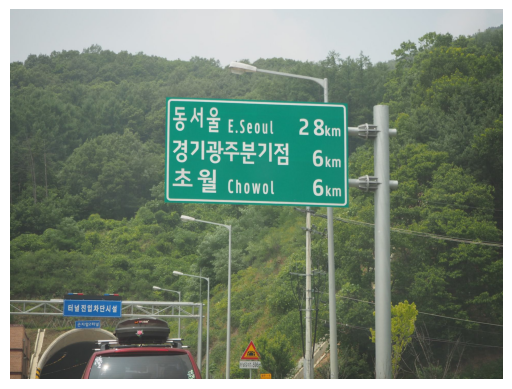

In [10]:
plt.imshow(cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

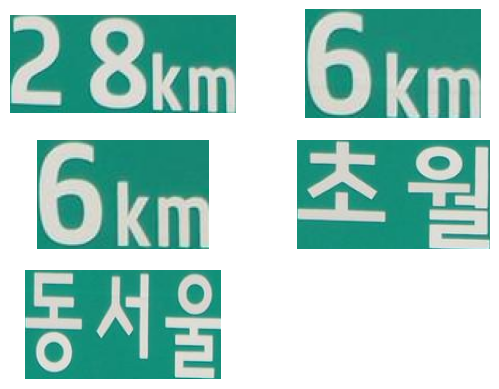

In [11]:
fig = plt.figure()
rows = (len(sample_cropped_img)//2)+1
cols = 2

for idx, sample in enumerate(sample_cropped_img):
    img = sample['image']
    ax = fig.add_subplot(rows, cols, idx+1)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.axis('off')
plt.show()

## Config 수정

In [ ]:
root = '/content/mini_project_4/mmocr_custom/mini_project_4/mmocr_custom/'

In [ ]:
cfg = Config.fromfile('configs/textrecog/crnn/crnn_mini-vgg_5e_toy.py')

In [ ]:
cfg.keys()

dict_keys(['default_scope', 'env_cfg', 'randomness', 'default_hooks', 'log_level', 'log_processor', 'load_from', 'resume', 'val_evaluator', 'test_evaluator', 'vis_backends', 'visualizer', 'tta_model', 'toy_data_root', 'toy_rec_train', 'toy_rec_test', 'optim_wrapper', 'train_cfg', 'val_cfg', 'test_cfg', 'param_scheduler', 'dictionary', 'model', 'train_pipeline', 'test_pipeline', 'tta_pipeline', 'train_list', 'test_list', 'train_dataloader', 'val_dataloader', 'test_dataloader'])

In [ ]:
cfg.toy_data_root = anns_and_img_dir

cfg.toy_rec_train.data_root = anns_and_img_dir
cfg.toy_rec_train.data_prefix.img_path = 'temp_Sign_cropped'
cfg.toy_rec_train.ann_file = 'recog_trian_annotation.json'

cfg.toy_rec_test.data_root = anns_and_img_dir
cfg.toy_rec_test.data_prefix.img_path = 'temp_Sign_cropped'
cfg.toy_rec_test.ann_file = 'recog_test_annotation.json'

cfg.train_list[0].data_root = anns_and_img_dir
cfg.train_list[0].data_prefix.img_path = 'temp_Sign_cropped/'
cfg.train_list[0].ann_file = 'recog_trian_annotation.json'

cfg.test_list[0].data_root = anns_and_img_dir
cfg.test_list[0].data_prefix.img_path = 'temp_Sign_cropped/'
cfg.test_list[0].ann_file = 'recog_test_annotation.json'

cfg.train_cfg.max_epochs = 15
cfg.train_cfg.val_interval = 2

cfg.dictionary.dict_file = root + 'dicts/kor_digits.txt'
cfg.model.decoder.dict_file = root + 'dicts/kor_digits.txt'

cfg.train_dataloader.batch_size = 10
cfg.train_dataloader.num_workers = 1

cfg.train_dataloader.dataset.datasets[0].data_root = anns_and_img_dir
cfg.train_dataloader.dataset.datasets[0].data_prefix.img_path = 'temp_Sign_cropped/'
cfg.train_dataloader.dataset.datasets[0].ann_file = 'recog_train_annotation.json'

cfg.val_dataloader.batch_size = 1
cfg.val_dataloader.num_workers = 1
cfg.val_dataloader.dataset.datasets[0].data_root = anns_and_img_dir
cfg.val_dataloader.dataset.datasets[0].data_prefix.img_path = 'temp_Sign_cropped/'
cfg.val_dataloader.dataset.datasets[0].ann_file = 'recog_test_annotation.json'

cfg.test_dataloader.batch_size = 1
cfg.test_dataloader.num_workers = 1
cfg.test_dataloader.dataset.datasets[0].data_root = anns_and_img_dir
cfg.test_dataloader.dataset.datasets[0].data_prefix.img_path = 'temp_Sign_cropped/'
cfg.test_dataloader.dataset.datasets[0].ann_file = 'recog_test_annotation.json'

cfg.work_dir = 'work_dirs/test_rec/'

cfg.optim_wrapper.optimizer.lr = 1e-3

In [ ]:
print(f'Config:\n{cfg.pretty_text}')

Config:
default_scope = 'mmocr'
env_cfg = dict(
    cudnn_benchmark=False,
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0),
    dist_cfg=dict(backend='nccl'))
randomness = dict(seed=None)
default_hooks = dict(
    timer=dict(type='IterTimerHook'),
    logger=dict(type='LoggerHook', interval=50),
    param_scheduler=dict(type='ParamSchedulerHook'),
    checkpoint=dict(type='CheckpointHook', interval=1),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    sync_buffer=dict(type='SyncBuffersHook'),
    visualization=dict(
        type='VisualizationHook',
        interval=1,
        enable=False,
        show=False,
        draw_gt=False,
        draw_pred=False))
log_level = 'INFO'
log_processor = dict(type='LogProcessor', window_size=10, by_epoch=True)
load_from = None
resume = False
val_evaluator = dict(
    type='MultiDatasetsEvaluator',
    metrics=[
        dict(
            type='WordMetric',
            mode=['exact', 'ignore_case', 'ignore_case_symbol']),
        

## 모델 훈련

In [ ]:
from mmengine.runner import Runner
import time

# Optionally, give visualizer a unique name to avoid dupliate instance being
# created in multiple runs
cfg.visualizer.name = f'{time.localtime()}'

runner = Runner.from_cfg(cfg)
runner.train()

05/18 18:14:19 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 1699422296
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50

CRNN(
  (data_preprocessor): TextRecogDataPreprocessor()
  (backbone): MiniVGG(
    (cnn): Sequential(
      (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu0): ReLU(inplace=True)
      (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1): ReLU(inplace=True)
      (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
      (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu3): ReLU(inplace=True)
      (pooling2): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
      (conv4): Conv2d(256, 512, kernel

## 모델 예측

In [ ]:
runner.test()

05/18 18:17:42 - mmengine - INFO - Epoch(test) [ 50/617]    eta: 0:00:04  time: 0.0065  data_time: 0.0011  memory: 220  
05/18 18:17:42 - mmengine - INFO - Epoch(test) [100/617]    eta: 0:00:03  time: 0.0051  data_time: 0.0008  memory: 136  
05/18 18:17:43 - mmengine - INFO - Epoch(test) [150/617]    eta: 0:00:02  time: 0.0044  data_time: 0.0008  memory: 137  
05/18 18:17:43 - mmengine - INFO - Epoch(test) [200/617]    eta: 0:00:02  time: 0.0045  data_time: 0.0008  memory: 136  
05/18 18:17:43 - mmengine - INFO - Epoch(test) [250/617]    eta: 0:00:02  time: 0.0046  data_time: 0.0009  memory: 136  
05/18 18:17:43 - mmengine - INFO - Epoch(test) [300/617]    eta: 0:00:01  time: 0.0045  data_time: 0.0008  memory: 136  
05/18 18:17:44 - mmengine - INFO - Epoch(test) [350/617]    eta: 0:00:01  time: 0.0059  data_time: 0.0014  memory: 136  
05/18 18:17:44 - mmengine - INFO - Epoch(test) [400/617]    eta: 0:00:01  time: 0.0047  data_time: 0.0012  memory: 137  
05/18 18:17:44 - mmengine - INFO

OrderedDict([('Toy/recog/word_acc', 0.0),
             ('Toy/recog/word_acc_ignore_case', 0.0),
             ('Toy/recog/word_acc_ignore_case_symbol', 0.671),
             ('Toy/recog/char_recall', 0.0),
             ('Toy/recog/char_precision', 0.0)])

Loads checkpoint by local backend from path: /content/mini_project_4/mmocr_custom/mini_project_4/mmocr_custom/work_dirs/test_rec/epoch_15.pth


Output()

result: [{'text': '', 'scores': nan}]


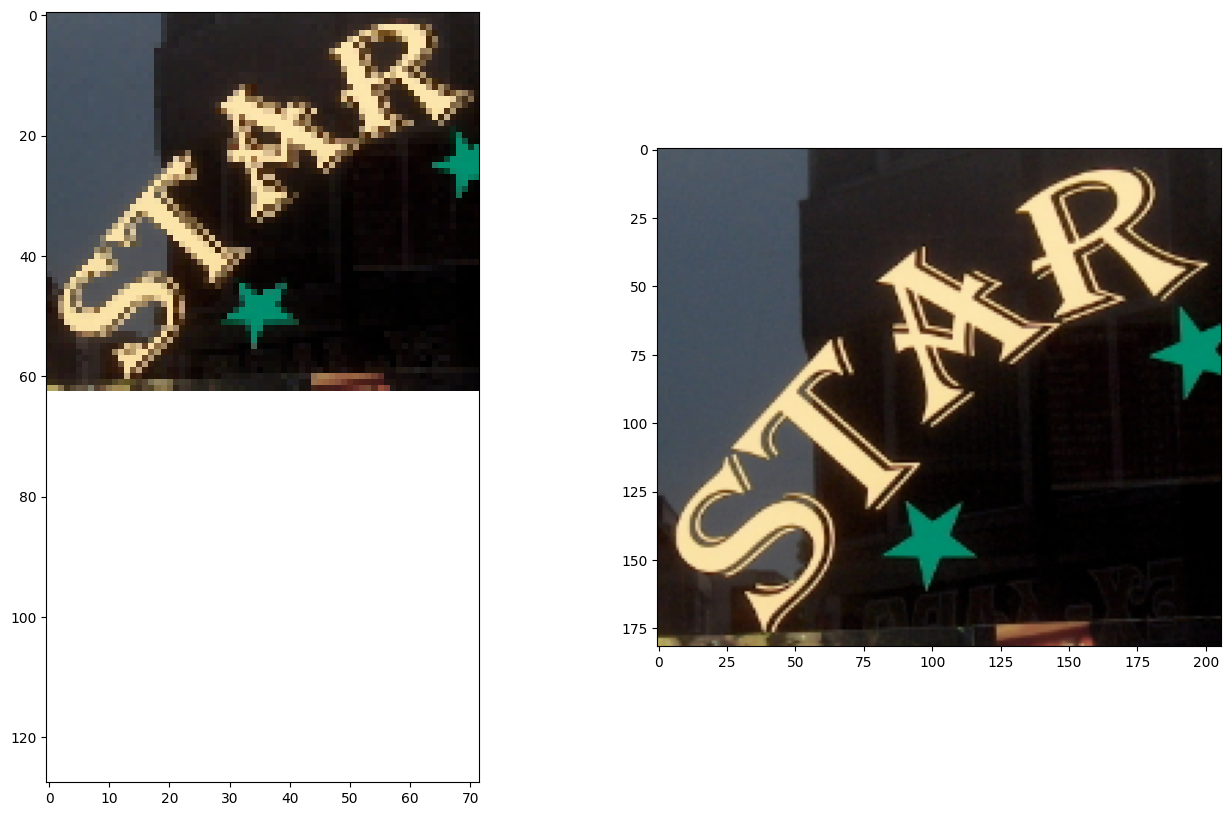

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from mmocr.apis import TextRecInferencer

img = '/content/mini_project_4/demo_text_recog.jpg'
checkpoint = '/content/mini_project_4/mmocr_custom/mini_project_4/mmocr_custom/work_dirs/test_rec/epoch_15.pth'


infer = TextRecInferencer(cfg, checkpoint)
result = infer(img, return_vis=True)

print(f'result: {result["predictions"]}' )
# ex = [round(x) for x in result["predictions"][0]["polygons"][0]]
# print(f'result: {ex}')

fig, ax = plt.subplots(1,2,figsize=(16,10))
ax[0].imshow(result['visualization'][0])
img = cv2.imread(img)
ax[1].imshow(np.asarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
plt.show()